In [1]:
import xarray as xa
import rioxarray as rxa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
from glob import glob
from os.path import join
import scipy
from scipy.stats import mannwhitneyu, linregress

In [2]:
def datarray_to_numpy(x, y):
    if type(x)== xa.core.dataarray.DataArray:
        x_dirty = x.values.ravel()
        y = y.values.ravel()
    else:
        x_dirty = x
    x = x_dirty[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    y = y[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    return x, y
    
def r2_value(x, y):
    x, y = datarray_to_numpy(x,y)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(f'slope: {slope}. intercept: {intercept}. r_value {r_value}. p value: {p_value}')
    return slope, intercept, x, y

def mann_test(x, y, xlabel = 'x', ylabel = 'y'):
    x, y = datarray_to_numpy(x,y)
    stat, p = mannwhitneyu(x, y)   
    print(f'Comparison of {xlabel} vs {ylabel} center has a p value of {p:.10f} of not being from same distribution with {len(x)} observations.')
    if p < 0.1:
        print(f'Median of {xlabel}: {np.median(x)} compared to median of {ylabel}: {np.median(y)}')

# Grand Mesa

In [3]:
ds = xa.open_dataset('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/GM_cor_vv.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/GM_cor_vv.nc'

In [ ]:
sd1 = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/ASO_GrandMesa_2020Feb1-2_snowdepth_3m.tif')
sd2 = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/ASO_GrandMesa_2020Feb13_snowdepth_3m.tif')

In [ ]:
coarse = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/gm_coarse.tiff')
sd1_re = sd1.rio.reproject_match(coarse)
sd1_re = sd1_re.where(sd1_re < 50)
sd2_re = sd2.rio.reproject_match(coarse)
sd2_re = sd2_re.where(sd2_re < 50)
sd1_re= sd1_re.assign_coords(band=['feb1'])
sd2_re= sd2_re.assign_coords(band=['feb13'])
ds = ds.rio.set_crs(coarse.rio.crs)
ds = ds.reset_coords()
ds = ds.drop('spatial_ref')
ds['sd1'] = sd1_re
ds['sd2'] = sd2_re
trees = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/gm_tree_cover.tif')
trees = trees.rio.reproject_match(coarse)
inc = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/grmesa_27416_20005_007_200212_L090_CX_01.inc.tiff')
inc = inc.rio.reproject_match(coarse)
elev = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/gm_dem.tiff')
elev = elev.rio.reproject_match(coarse)
roughness = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/gm_roughness.tiff')
roughness = roughness.where(roughness>0)
roughness = roughness.rio.reproject_match(coarse)
lc = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_GM/gm_landcover.tif')
lc = lc.rio.reproject_match(coarse)
water = lc.where(lc == 579)

cor = ds.sel({'band':'grmesa_27416_20003-028_20005-007_0011d'})['cor_vv']

MannwhitneyuResult(statistic=254607559772.5, pvalue=0.0)


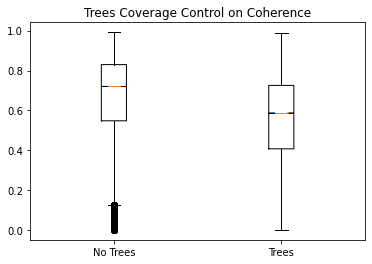

In [ ]:
a = cor.where(trees== 0).values.ravel()
b = cor.where(trees== 1).values.ravel()
a = a[~np.isnan(a)]
b = b[~np.isnan(b)]
print(mannwhitneyu(a, b))
data = [cor.values[trees.values[0] == 0], cor.values[trees[0].values == 1]]
data = [d[~np.isnan(d)] for d in data]
plt.boxplot(data, notch = True)
plt.xticks(labels = ['No Trees', 'Trees'], ticks = [1,2])
plt.title('Trees Coverage Control on Coherence')
plt.show()

slope: -0.20005517169682255. intercept: 0.8281805039714925. r_value -0.29051141362733596. p value: 0.0


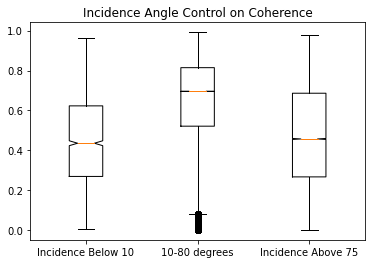

In [ ]:
r2_value(inc, cor)
data = [cor.values[inc.values[0] < np.deg2rad(10)] ,cor.values[(inc.values[0] < np.deg2rad(80)) & (inc.values[0] > np.deg2rad(10))], cor.values[inc[0].values > np.deg2rad(80)]]
data = [d[~np.isnan(d)] for d in data]
plt.boxplot(data, notch = True)
plt.xticks(labels = ['Incidence Below 10','10-80 degrees', 'Incidence Above 75'], ticks = [1,2,3])
plt.title('Incidence Angle Control on Coherence')
plt.show()

MannwhitneyuResult(statistic=5110218558.0, pvalue=0.0)


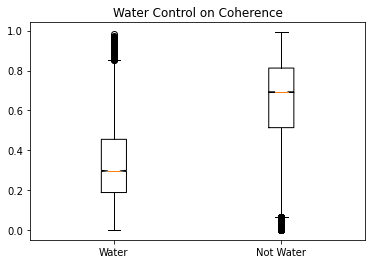

In [ ]:
a = cor.where(water== water.mean().values).values.ravel()
b = cor.where(water!= water.mean().values).values.ravel()
a = a[~np.isnan(a)]
b = b[~np.isnan(b)]
print(mannwhitneyu(a, b))
data = [cor.values[water.values[0] == water.mean().values], cor.values[water[0].values != water.mean().values]]
data = [d[~np.isnan(d)] for d in data]
plt.boxplot(data, notch = True)
plt.xticks(labels = ['Water','Not Water'], ticks = [1,2])
plt.title('Water Control on Coherence')
plt.show()

slope: -0.0002252604739263934. intercept: 0.6452190276440202. r_value -0.012861383317108916. p value: 5.940730422843055e-54


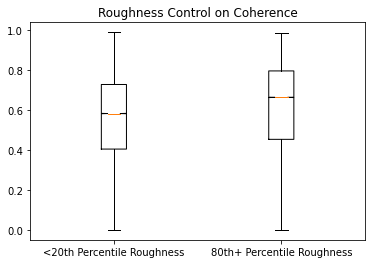

In [ ]:
r2_value(roughness, cor)
data = [cor.values[roughness.values[0] < np.nanpercentile(roughness, 20)], cor.values[roughness[0].values > np.nanpercentile(roughness, 80)]]
data = [d[~np.isnan(d)] for d in data]
plt.boxplot(data, notch = True)
plt.xticks(labels = ['<20th Percentile Roughness','80th+ Percentile Roughness'], ticks = [1,2])
plt.title('Roughness Control on Coherence')
plt.show()

slope: -0.02532966106437589. intercept: 0.5605511565053458. r_value -0.049189749120167624. p value: 4.642897644973991e-158


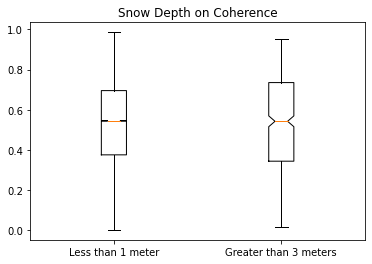

In [ ]:
r2_value(sd1_re, cor)
data = [cor.values[sd1_re.values[0] < 1], cor.values[sd1_re[0].values > 3]]
data = [d[~np.isnan(d)] for d in data]
plt.boxplot(data, notch = True)
plt.xticks(labels = ['Less than 1 meter', 'Greater than 3 meters'], ticks = [1,2])
plt.title('Snow Depth on Coherence')
plt.show()

In [ ]:
r2_value(sd1_re, cor)
data = [cor.values[sd1_re.values[0] < 1], cor.values[sd1_re[0].values > 3]]
data = [d[~np.isnan(d)] for d in data]
plt.boxplot(data, notch = True)
plt.xticks(labels = ['Less than 1 meter', 'Greater than 3 meters'], ticks = [1,2])
plt.title('Snow Depth on Coherence')
plt.show()

In [ ]:
control = (trees[0].values != 0) & (inc[0].values > np.deg2rad(30)) & (inc[0].values < np.deg2rad(50)) & (roughness[0].values > np.nanpercentile(roughness[0].values, 50)) & (water[0].values != water.mean().values)

slope: 0.00164242435832898. intercept: 0.6390208799353537. r_value 0.006452681182988729. p value: 0.6440066031381285


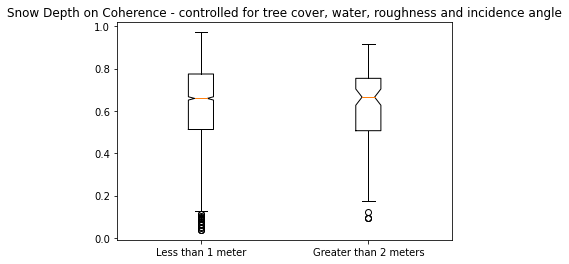

In [ ]:
cor_bare_low = cor.values[control]
sd_bare_low = sd1_re[0].values[control]
r2_value(sd_bare_low, cor_bare_low)
data = [cor_bare_low[(sd_bare_low < 1) & (sd_bare_low > 0)], cor_bare_low[sd_bare_low > 2]]
data = [d[~np.isnan(d)] for d in data]
plt.boxplot(data, notch = True)
plt.xticks(labels = ['Less than 1 meter', 'Greater than 2 meters'], ticks = [1,2])
plt.title('Snow Depth on Coherence - controlled for tree cover, water, roughness and incidence angle')
plt.show()

slope: 0.00013004182997040272. intercept: 0.26467448956176. r_value 0.14769250488249863. p value: 0.0


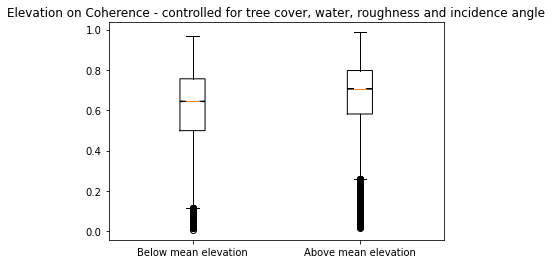

In [ ]:
elev_bare_low = elev[0].values[control]
r2_value(elev_bare_low, cor_bare_low)
data = [cor_bare_low[elev_bare_low < np.mean(elev_bare_low)], cor_bare_low[elev_bare_low > np.mean(elev_bare_low)]]
data = [d[~np.isnan(d)] for d in data]
plt.boxplot(data, notch = True)
plt.xticks(labels = ['Below mean elevation', 'Above mean elevation'], ticks = [1,2])
plt.title('Elevation on Coherence - controlled for tree cover, water, roughness and incidence angle')
plt.show()

In [ ]:
# r2_value(elev_bare_low, sd_bare_low)
# data = [sd_bare_low[elev_bare_low < np.mean(elev_bare_low)], sd_bare_low[elev_bare_low > np.mean(elev_bare_low)]]
# data = [d[~np.isnan(d)] for d in data]
# plt.boxplot(data, notch = True)
# plt.xticks(labels = ['Below mean elevation', 'Above mean elevation'], ticks = [1,2])
# plt.ylim(0, 3)
#plt.title('Elevation on Snow Depth - controlled for tree cover and incidence angle')
# plt.show()

## Lowman

In [ ]:
ds = xa.open_dataset('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_lowman/cor_vv.nc')

In [ ]:
import pickle
with open('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_lowman/cor_coarse.pkl', 'rb') as f:
    coarse = pickle.load(f)

In [ ]:
cor = ds.sel({'band':'lowman_23205_21015-008_21017-018_0007d'})['cor_vv']

In [ ]:
trees = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_lowman/veg_height.tiff')
trees = trees.rio.reproject_match(coarse)

dem = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_lowman/dem.tiff')
dem = dem.rio.reproject_match(coarse)

inc = rxa.open_rasterio('/Users/zachkeskinen/Documents/uavsar/data/coherence_spatial_lowman/lowman_23205_20002_007_200131_L090_CX_01.inc.tiff')
inc = inc.rio.reproject_match(coarse)